# Build graph from dataframe
In this notebook, we execute the k-NN algorithm to build a graph from an initial dataframe. In the k-NN algorithm, each node is connected to its k nearest neighbors.

## Notebook plan : 
1. Reading the dataset
2. 1st method : k-NN with all features
3. 2nd method : split per tumour before using k-NN
4. 3rd method : split with clustering method before using k-NN

In [1]:
import pandas as pd
import numpy as np
from models.BuildGraph import BuildGraph
from utils.preProcessing import preProcessing

In [2]:
preprocessor = preProcessing()

## 1. Reading dataset

In [3]:
df = pd.read_excel('data/Supplemental-table1.xlsx')
df = df.loc[df["Cohort"] == "Naive"]
df

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,...,Alive_0,Time to progression (days),Progression_1,Clinical benefit,CD8+ T cell score,Exome mut per mb,Genome mut per mb,CD274 expression,M1M2 expression,Lymph related
0,14891,EGAD00001001961,LUNG,F,8,Nivolumab,Naive,Progression,Mixed,45,...,1,179,1,NCB,0.351869,11.095310,23.0729,4.1689,55.51575,Non-lymph related
1,18624,EGAD00001002047,AECA,F,10,Nivolumab,Naive,Progression,Stable disease,47,...,1,148,1,NCB,0.071464,3.876336,5.4552,0.7910,9.32352,Non-lymph related
2,21392,EGAD00001002544,OV,F,6,Monalizumab,Naive,Progression,Physician assessed SD,57,...,1,79,1,NCB,0.040394,2.415688,4.1274,4.0377,50.12008,Lymph related
3,21516,EGAD00001002546,SKCM,F,3,Ipilimumab,Naive,Death,Not evaluable,29,...,1,11,0,NCB,0.052774,6.235845,11.4871,0.6006,1.58550,Non-lymph related
4,22186,EGAD00001001966,LUNG,F,4,Atezolizumab,Naive,Progression,Stable disease,52,...,1,80,1,NCB,0.009323,4.606660,7.1503,1.8234,38.42695,Non-lymph related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,39280,EGAD00001004933,LUNG,M,2,Pembrolizumab,Naive,Toxicity,Physician Assessed SD,60,...,1,401,0,DCB,0.695396,84.998501,96.4079,8.4768,86.62561,Non-lymph related
94,37899,EGAD00001005838,CHOL,F,2,Nivolumab,Naive,Death,Physician assessed PR,38,...,1,96,0,NCB,0.818233,2.247151,2.7416,11.2704,47.97376,Non-lymph related
95,37775,EGAD00001004934,HNSC,M,1,Avelumab/OX40 agonist PF-04518600,Naive,Progression,Stable disease,69,...,1,69,1,NCB,0.018982,3.848247,5.8036,8.7136,5.13403,Non-lymph related
96,38313,EGAD00001005844,ACC,F,3,Avelumab/Debio1143 (SMAC mimetic),Naive,Toxicity,Partial response,34,...,1,51,1,NCB,0.000000,5.617878,7.7940,0.0688,0.51364,Non-lymph related


## 2. 1st method : k-NN with all features
The useful features to evaluate patients similarity are :
- Tumour type
- Sex
- Immunotherapy regimen
- Age
- CD8+ T cell score
- M1M2 expression score
- Genome mut per mb
- Exome mut per mb
- CD274 expression

Some of these features are categorical, so we need to numerize them.

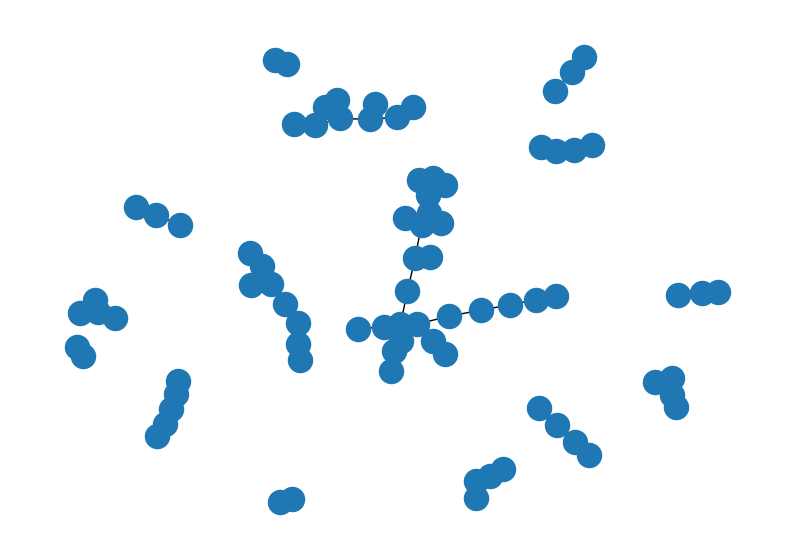

In [4]:
# Data numerization and normalization
df_numerized = pd.get_dummies(df.loc[:,["Tumour type","Sex","Immunotherapy regimen","Age at advanced disease diagnosis","CD8+ T cell score","M1M2 expression","Genome mut per mb","Exome mut per mb","CD274 expression"]]).astype(float)
X_numerized = preprocessor.normalize_data(df_numerized.to_numpy())

# Building graph (adjacency matrix)
buildgraph = BuildGraph(k=2, metric="euclidean")
A = buildgraph.apply_knn(X_numerized)

# Vizualize the graph
buildgraph.show_graph(A)

## 3. 2nd method : split per tumour type before using k-NN

### Split the whole dataframe into sub-dataframes with the tumour type

In [5]:
def split_per_column(df:pd.DataFrame, column_name:str)->dict:
    """ 
    Split the dataframe df into distinct groups, depending on the column_name values.

    ### Parameters :
    - df : the dataframe to split.
    - column_name : the name of the column used to make the split.

    ### Returns :
    A dictionary, where key = column value, and value = sub dataframe.
    """
    column_values = np.unique(df[column_name].to_numpy())
    dico = {}
    for i in range(column_values.shape[0]):
        dico[column_values[i]] = df.loc[df[column_name] == column_values[i]]
    return dico

dico_tumour_type = split_per_column(df, "Tumour type")

### For each sub-dataframe, compute the local adjacency matrix

In [6]:
def compute_local_adjacency_matrices(dico_df: dict, columns:list[str])->np.ndarray:
    """ 
    Compute the local adjacency matrix for each dataframe in dico_df with k-NN
    """
    matrices = []

    # For each sub dataframe, we estimate the corresponding adjacency matrix.
    for col_value in list(dico_df.keys()):
        sub_df = pd.get_dummies(dico_df[col_value].loc[:,columns]).astype(float)
        sub_X = preprocessor.normalize_data(sub_df.to_numpy())
        A_local = buildgraph.apply_knn(sub_X)
        matrices.append(A_local)

    return matrices

columns = ["Tumour type","Sex","Immunotherapy regimen","Age at advanced disease diagnosis","CD8+ T cell score","M1M2 expression","Genome mut per mb","Exome mut per mb","CD274 expression"]
matrices_tumour = compute_local_adjacency_matrices(dico_tumour_type, columns)

### Merge the local adjacency matrices of distinct subgraphs to obtain the whole graph

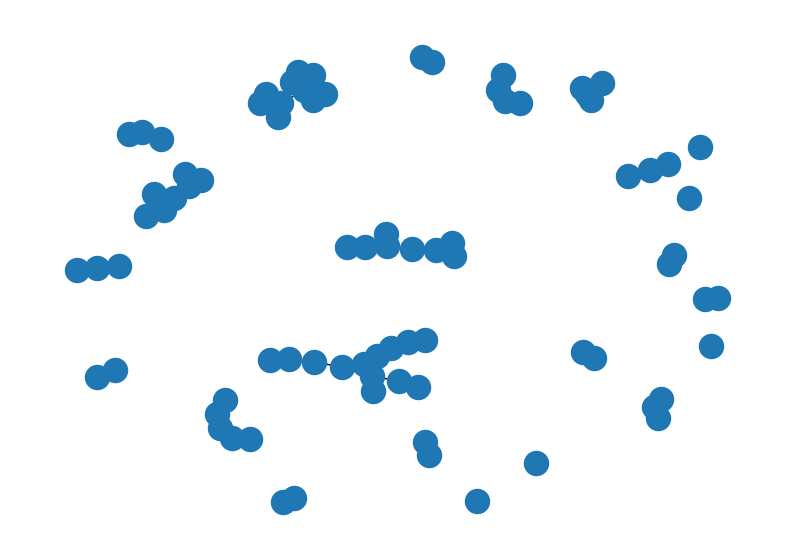

In [7]:
global_A_tumour = buildgraph.merge_adjacency_matrix(matrices_tumour)

# Show graph
buildgraph.show_graph(global_A_tumour)

## 3. Evaluate neighbors similarity
Now, we want to evaluate if 2 patients which are considered as neighbors have some important features in common.

### a. Tumour type

In [11]:
tumour_similarity = buildgraph.proportion_similarity_neighbors(A, df["Tumour type"].to_numpy())
print(f"{tumour_similarity*100} % of neighbor patients have the same tumour")

83.0 % of neighbor patients have the same tumour


## 4. Evaluate gathering
We want to check, for each patient, how many patients have the same tumour type, age, treatment...
Typically : "75% des voisins du patient 12 ont la même tumeur que lui" --> En moyenne, 75% des voisins sont de la même tumeur.

In [ ]:
# def get_patient_neighbors(row_A):
#     """ 
#     Get index of neighbors of the patient, from the row of the adjacency matrix.
#     """
#     return np.where(row_A == 1)

# def estimate_similarity_tumour(A, tumour_col):
#     """
    
#     """
#     mean_similarity = 0
#     for i in range(A.shape[0]):
#         tumour_i = tumour_col[i]
#         tumour_neighbors = tumour_col[get_patient_neighbors(A[i])]
#         print(tumour_neighbors)
#         print(np.where(tumour_neighbors == tumour_i))
#         similarity_patient_i = np.count_nonzero(np.where(tumour_neighbors == tumour_i)) / tumour_neighbors.shape[0] #-1 car on ne compte pas i-i comme positif
#         mean_similarity += similarity_patient_i
#         print(f"Patient {i} : {similarity_patient_i*100} % des patients voisins ont la même tumeur ({tumour_i})")
#     return mean_similarity/A.shape[0]

In [ ]:
# tumour_col = df["Tumour type"].to_numpy()
# similarity_tumour = estimate_similarity_tumour(A, tumour_col)
# print(f"En moyenne, {similarity_tumour*100} % des patients voisins partagent la même tumeur.")